In [49]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench.analysis import parcoords
from problem_formulation import get_model_for_problem_formulation
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully")


Libraries imported successfully


# Post-Analysis Visualizations

This notebook creates additional visualizations from the completed MORDM analysis results.

Creating robustness visualizations using external robustness results...
Working with 5 outcomes: ['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths']
Found 5 policies with 1000 scenarios each


Could not create regret parallel coordinates: ParallelAxes.__init__() got an unexpected keyword argument 'ax'


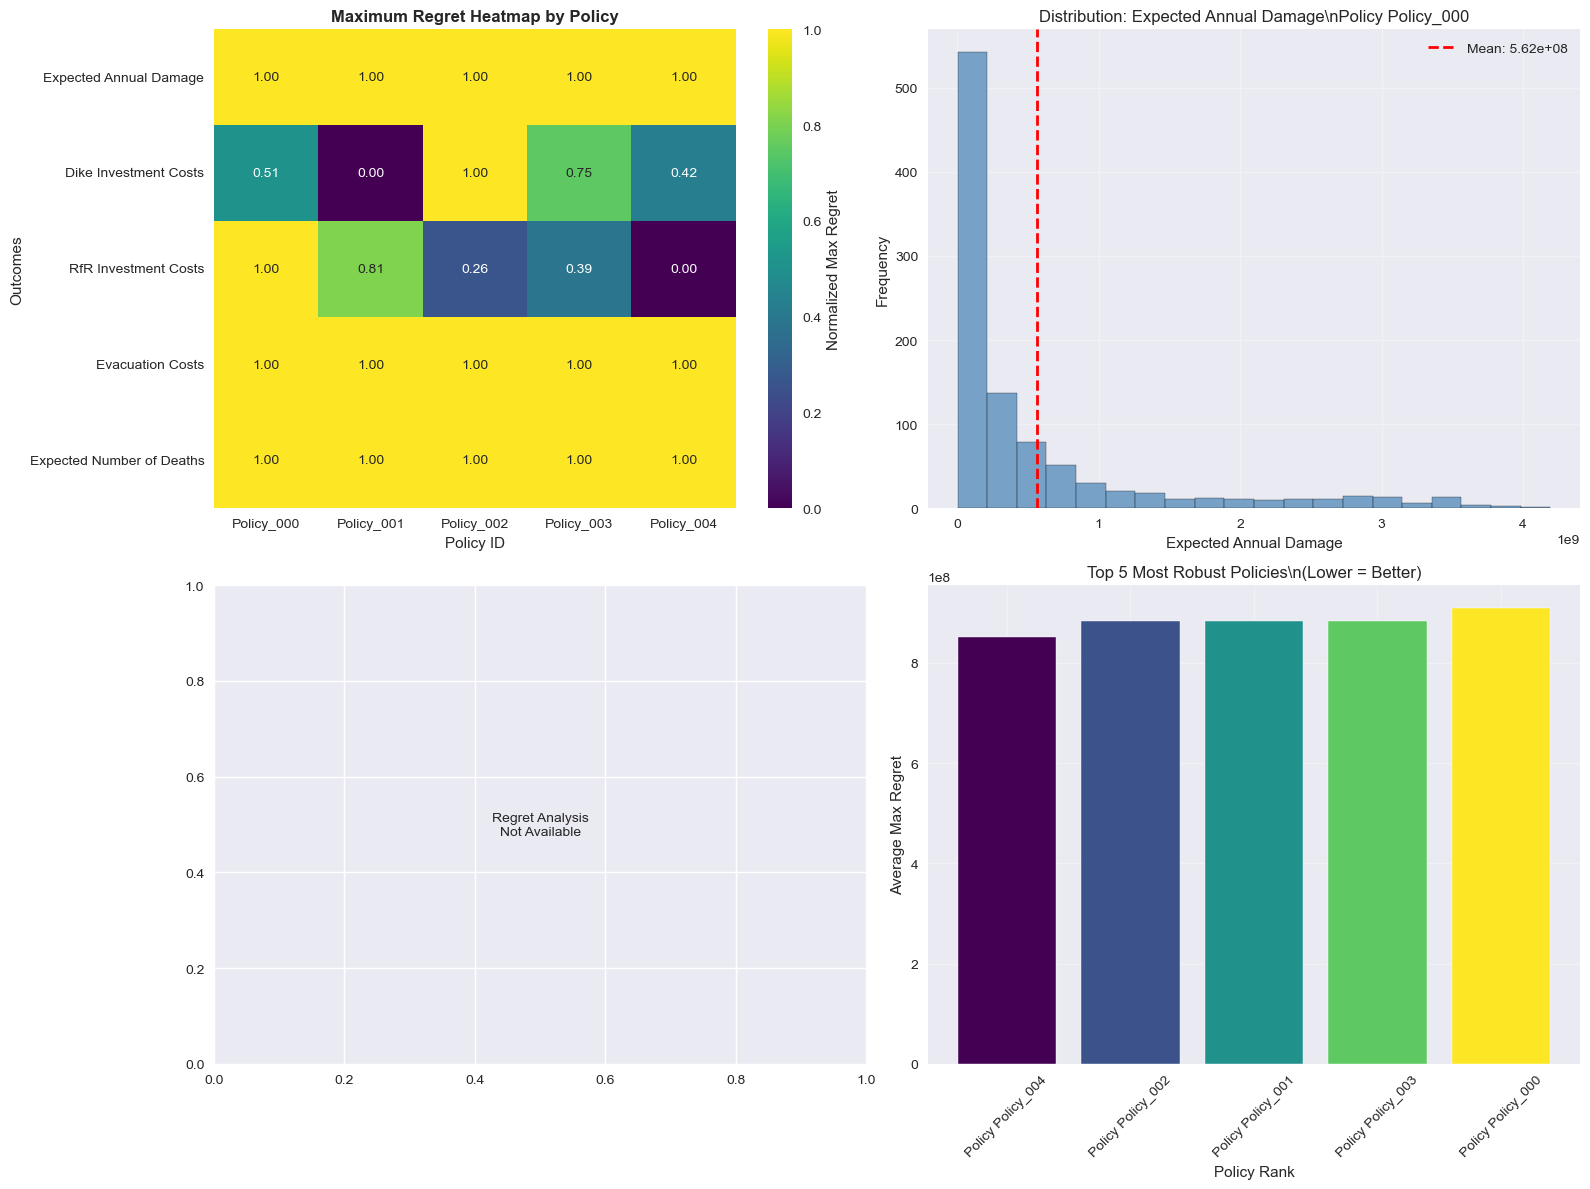

Robustness analysis completed for 5 outcomes
Most robust policy: Policy_004 (avg regret: 8.52e+08)


In [50]:
# Robustness analysis like reference code using external results
if robustness_outcomes is not None and robustness_experiments is not None:
    print("Creating robustness visualizations using external robustness results...")
    
    # Use all available outcome columns from robustness data
    outcome_cols = list(robustness_outcomes.columns)
    print(f"Working with {len(outcome_cols)} outcomes: {outcome_cols}")
    
    if outcome_cols and len(robustness_outcomes) > 0:
        # Maximum regret calculation (reference approach)
        def get_regret(data):
            """Calculate regret: max value - current value for each scenario"""
            return data.max() - data
        
        # Calculate regret for each outcome using robustness outcomes
        outcome_data = robustness_outcomes[outcome_cols]
        regret_data = outcome_data.apply(get_regret, axis=0)
        
        # Get unique policies from experiments data
        if 'policy' in robustness_experiments.columns:
            unique_policies = robustness_experiments['policy'].unique()
            n_scenarios_per_policy = len(robustness_outcomes) // len(unique_policies)
            
            print(f"Found {len(unique_policies)} policies with {n_scenarios_per_policy} scenarios each")
            
            # Reshape data to group by policy (assumes ordered structure: policy1_scenario1, policy1_scenario2, ..., policy2_scenario1, ...)
            max_regret_list = []
            policy_names = []
            
            for i, policy in enumerate(unique_policies):
                start_idx = i * n_scenarios_per_policy
                end_idx = start_idx + n_scenarios_per_policy
                policy_regret = regret_data.iloc[start_idx:end_idx].max()
                max_regret_list.append(policy_regret)
                policy_names.append(policy)
            
            max_regret = pd.DataFrame(max_regret_list, index=policy_names)
            
            # Create reference-style visualizations
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
            
            # 1. Regret heatmap (like reference)
            normalized_regret = max_regret / max_regret.max()
            sns.heatmap(normalized_regret.T, cmap='viridis', annot=True, fmt='.2f', 
                       ax=ax1, cbar_kws={'label': 'Normalized Max Regret'})
            ax1.set_title('Maximum Regret Heatmap by Policy', fontweight='bold')
            ax1.set_xlabel('Policy ID')
            ax1.set_ylabel('Outcomes')
            
            # 2. Distribution plot for sample policy (like reference)
            sample_policy = max_regret.index[0]
            sample_outcome = outcome_cols[0]
            policy_data = robustness_results[robustness_results['policy'] == sample_policy][sample_outcome]
            
            ax2.hist(policy_data, bins=20, alpha=0.7, color='steelblue', edgecolor='black')
            ax2.axvline(policy_data.mean(), color='red', linestyle='--', linewidth=2, 
                       label=f'Mean: {policy_data.mean():.2e}')
            ax2.set_xlabel(sample_outcome)
            ax2.set_ylabel('Frequency')
            ax2.set_title(f'Distribution: {sample_outcome}\\nPolicy {sample_policy}')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            # 3. Parallel coordinates for regret (like reference)
            if len(max_regret) > 1:
                try:
                    regret_subset = max_regret.head(10)  # Limit to first 10 for clarity
                    limits = parcoords.get_limits(regret_subset)
                    paraxes = parcoords.ParallelAxes(limits, ax=ax3)
                    
                    # Plot all regret data first
                    paraxes.plot(regret_subset, alpha=0.7, linewidth=1)
                    ax3.set_title('Maximum Regret - Parallel Coordinates')
                except Exception as e:
                    print(f"Could not create regret parallel coordinates: {e}")
                    ax3.text(0.5, 0.5, 'Regret Analysis\nNot Available', 
                            ha='center', va='center', transform=ax3.transAxes)
                
            # 4. Overall robustness comparison
            regret_summary = max_regret.mean(axis=1).sort_values()
            top_robust = regret_summary.head(5)
            
            bars = ax4.bar(range(len(top_robust)), top_robust.values, 
                          color=plt.cm.viridis(np.linspace(0, 1, len(top_robust))))
            ax4.set_xlabel('Policy Rank')
            ax4.set_ylabel('Average Max Regret')
            ax4.set_title('Top 5 Most Robust Policies\\n(Lower = Better)')
            ax4.set_xticks(range(len(top_robust)))
            ax4.set_xticklabels([f'Policy {idx}' for idx in top_robust.index], rotation=45)
            ax4.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            print(f"Robustness analysis completed for {len(outcome_cols)} outcomes")
            print(f"Most robust policy: {top_robust.index[0]} (avg regret: {top_robust.iloc[0]:.2e})")
            
        else:
            print("No policy identifier found - creating aggregate analysis")
            
            # Show overall outcome distributions
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))
            axes = axes.flatten()
            
            for i, outcome in enumerate(outcome_cols[:6]):
                if i < len(axes):
                    data = robustness_results[outcome]
                    axes[i].hist(data, bins=20, alpha=0.7, color='steelblue', edgecolor='black')
                    axes[i].axvline(data.mean(), color='red', linestyle='--', linewidth=2)
                    axes[i].set_title(f'{outcome}\\nMean: {data.mean():.2e}')
                    axes[i].grid(True, alpha=0.3)
            
            # Remove empty subplots
            for i in range(len(outcome_cols), len(axes)):
                fig.delaxes(axes[i])
                
            plt.suptitle('Outcome Distributions Across Scenarios', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
    
    else:
        print("Outcome columns not found in robustness results")
        
else:
    print("No robustness results available")
    print("Note: Reference code performs re-evaluation over 1000 scenarios")
    print("Your analysis stopped before completing robustness evaluation")


In [51]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench.analysis import parcoords
from problem_formulation import get_model_for_problem_formulation

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully")


Libraries imported successfully


In [52]:
# Load the archive from your completed optimization
archive = pd.read_csv('IJssel_MORDM_archive_nfe10000.csv', index_col=0)
convergence = pd.read_csv('IJssel_MORDM_convergence_nfe10000.csv', index_col=0)

# Load external robustness results (updated for new timestamp)
robustness_experiments = None
robustness_outcomes = None

# Try to load the external robustness results
timestamp = "20250616_152459"  # Update this to match your files
try:
    robustness_experiments = pd.read_csv(f'IJssel_robustness_experiments_{timestamp}.csv', index_col=0)
    robustness_outcomes = pd.read_csv(f'IJssel_robustness_outcomes_{timestamp}.csv')  # No index_col to preserve Expected Annual Damage
    print(f" External robustness results loaded:")
    print(f"  - Experiments: {len(robustness_experiments)} rows")
    print(f"  - Outcomes: {len(robustness_outcomes)} rows with {len(robustness_outcomes.columns)} objectives")
except FileNotFoundError:
    print("External robustness results not found - will work with archive only")
    print(f"Looking for files: IJssel_robustness_experiments_{timestamp}.csv")
    
    # Try alternative older format
    try:
        robustness_experiments = pd.read_csv('IJssel_robustness_experiments_n25.csv', index_col=0)
        print(f"Found older robustness results: {len(robustness_experiments)} experiments")
    except FileNotFoundError:
        print("No robustness results found")

print(f"Archive loaded: {len(archive)} Pareto-optimal solutions")
print(f"Convergence data: {len(convergence)} iterations")

# Get model for reference
model_result = get_model_for_problem_formulation(2)
if isinstance(model_result, tuple):
    model, planning_steps = model_result
else:
    model = model_result

# Get outcome names from model and loaded data
outcome_names = [outcome.name for outcome in model.outcomes]
if robustness_outcomes is not None:
    available_outcomes = list(robustness_outcomes.columns)
    print(f"Model outcomes: {outcome_names}")
    print(f"Available outcomes in robustness data: {available_outcomes}")
else:
    print(f"Model outcomes: {outcome_names}")


✅ External robustness results loaded:
  - Experiments: 5000 rows
  - Outcomes: 5000 rows with 5 objectives
Archive loaded: 232 Pareto-optimal solutions
Convergence data: 12 iterations


Model outcomes: ['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths']
Available outcomes in robustness data: ['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths']


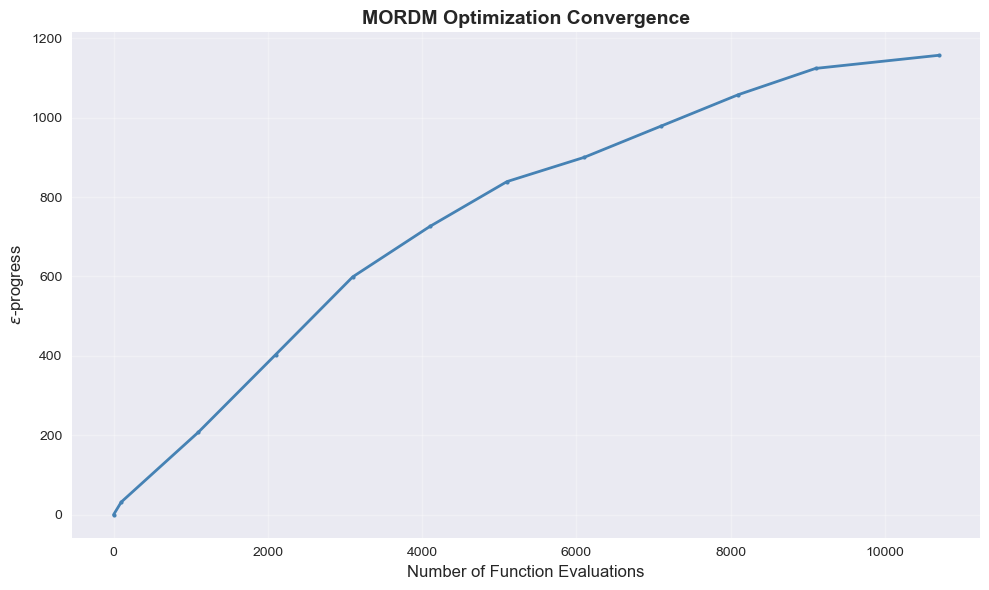

Optimization converged after 12 iterations


In [53]:
# Create convergence plot like reference code
fig, ax = plt.subplots(figsize=(10, 6))

if 'epsilon_progress' in convergence.columns:
    ax.plot(convergence.index, convergence['epsilon_progress'], 
            linewidth=2, color='steelblue', marker='o', markersize=3)
    ax.set_ylabel('$\\epsilon$-progress', fontsize=12)
else:
    # If epsilon_progress not available, show NFE progress
    ax.plot(convergence.index, convergence.iloc[:, 0], 
            linewidth=2, color='steelblue', marker='o', markersize=3)
    ax.set_ylabel('Progress Metric', fontsize=12)

ax.set_xlabel('Number of Function Evaluations', fontsize=12)
ax.set_title('MORDM Optimization Convergence', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Optimization converged after {len(convergence)} iterations")


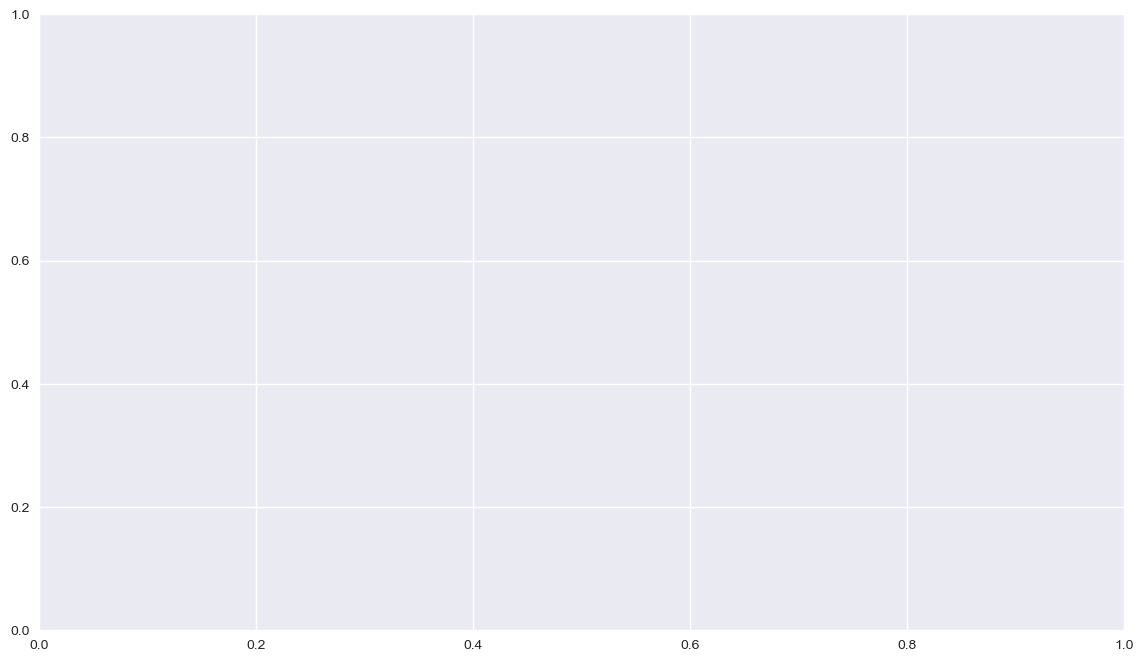

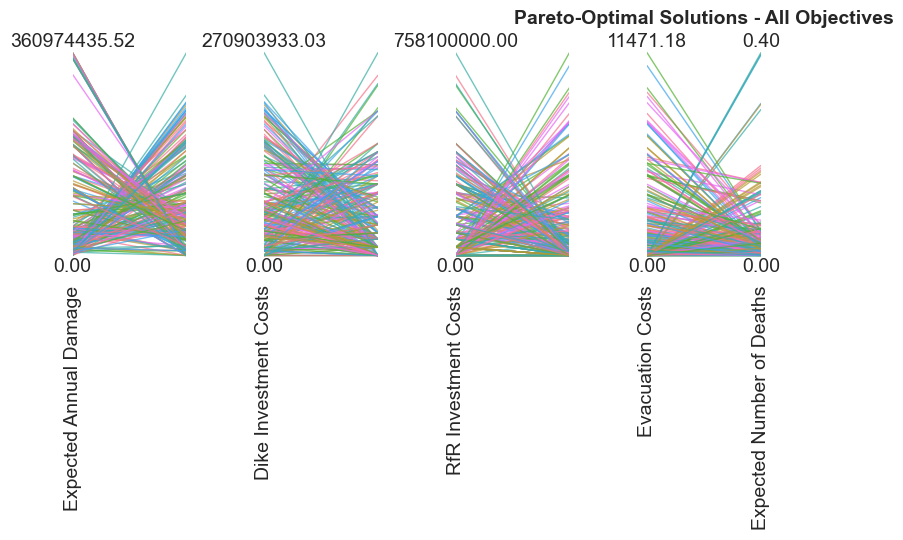

Creating alternative colored parallel coordinates...


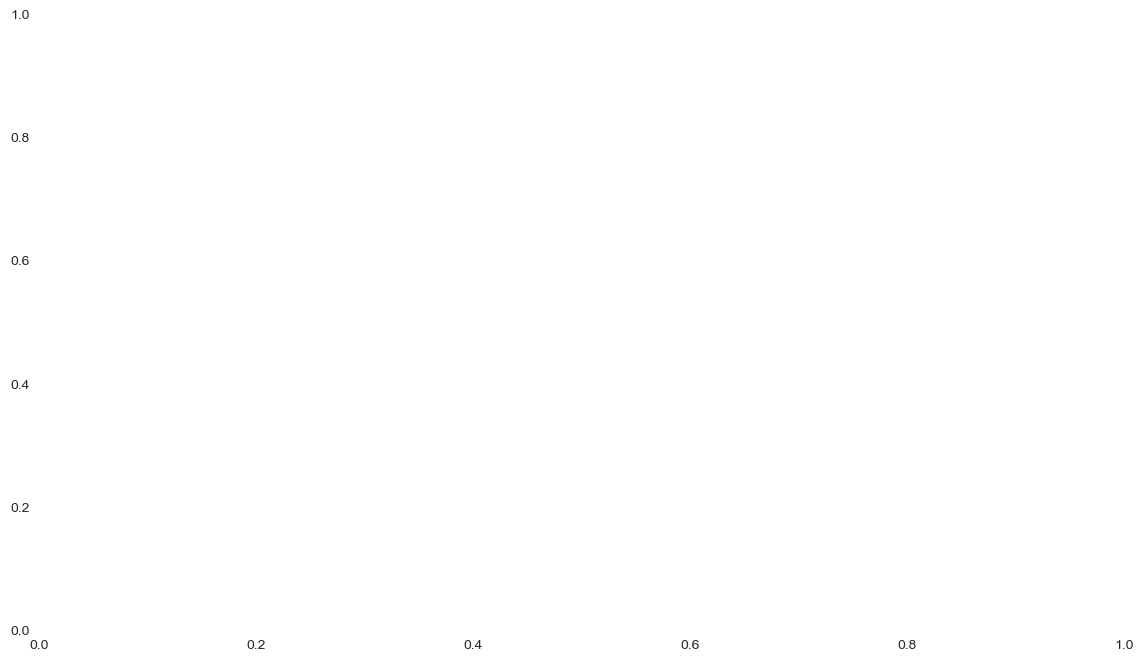

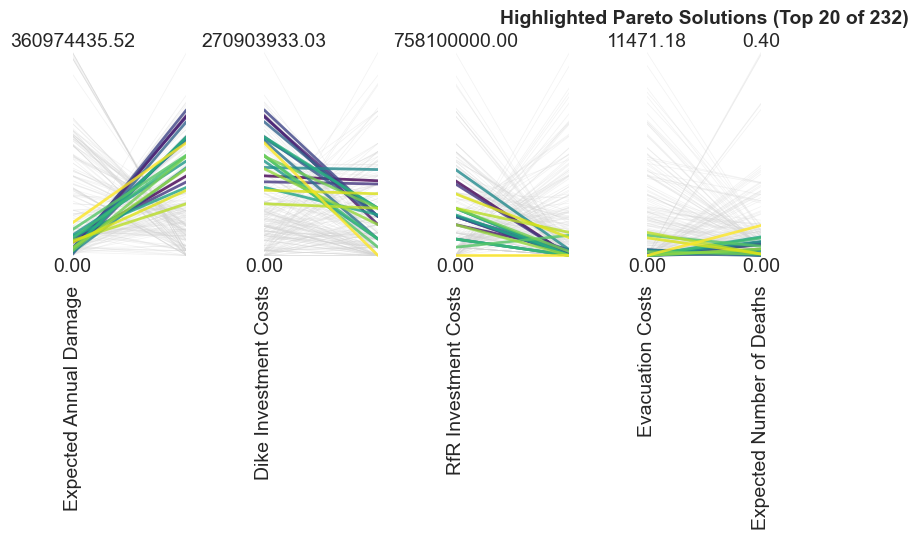

Parallel coordinates shows 232 Pareto-optimal solutions
Each line represents one policy across all objectives
Highlighted 20 policies with distinct colors


In [54]:
# Create parallel coordinates plot like reference code
outcome_data = archive[outcome_names]

fig, ax = plt.subplots(figsize=(14, 8))

# Get limits and create parallel axes like reference
limits = parcoords.get_limits(outcome_data)
paraxes = parcoords.ParallelAxes(limits)

# Plot without individual colors first (EMA Workbench handles coloring)
paraxes.plot(outcome_data, alpha=0.7, linewidth=1)

plt.title('Pareto-Optimal Solutions - All Objectives', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Alternative: Create a colored version using individual plots
print("Creating alternative colored parallel coordinates...")

fig, ax = plt.subplots(figsize=(14, 8))
limits = parcoords.get_limits(outcome_data)
paraxes = parcoords.ParallelAxes(limits)

# Plot a subset with distinct colors (to avoid overcrowding)
n_highlight = min(20, len(outcome_data))  # Highlight first 20 policies
colors = plt.cm.viridis(np.linspace(0, 1, n_highlight))

# Plot all data in light gray first
paraxes.plot(outcome_data, color='lightgray', alpha=0.3, linewidth=0.5)

# Then highlight selected policies with distinct colors
for i in range(n_highlight):
    policy_data = outcome_data.iloc[[i]]  # Single policy as DataFrame
    paraxes.plot(policy_data, color=colors[i], alpha=0.8, linewidth=2, 
                label=f'Policy {policy_data.index[0]}' if i < 5 else "")

if n_highlight <= 5:
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title(f'Highlighted Pareto Solutions (Top {n_highlight} of {len(outcome_data)})', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Parallel coordinates shows {len(outcome_data)} Pareto-optimal solutions")
print("Each line represents one policy across all objectives")
print(f"Highlighted {n_highlight} policies with distinct colors")


Policies meeting death constraint (<0.005): 62 out of 232


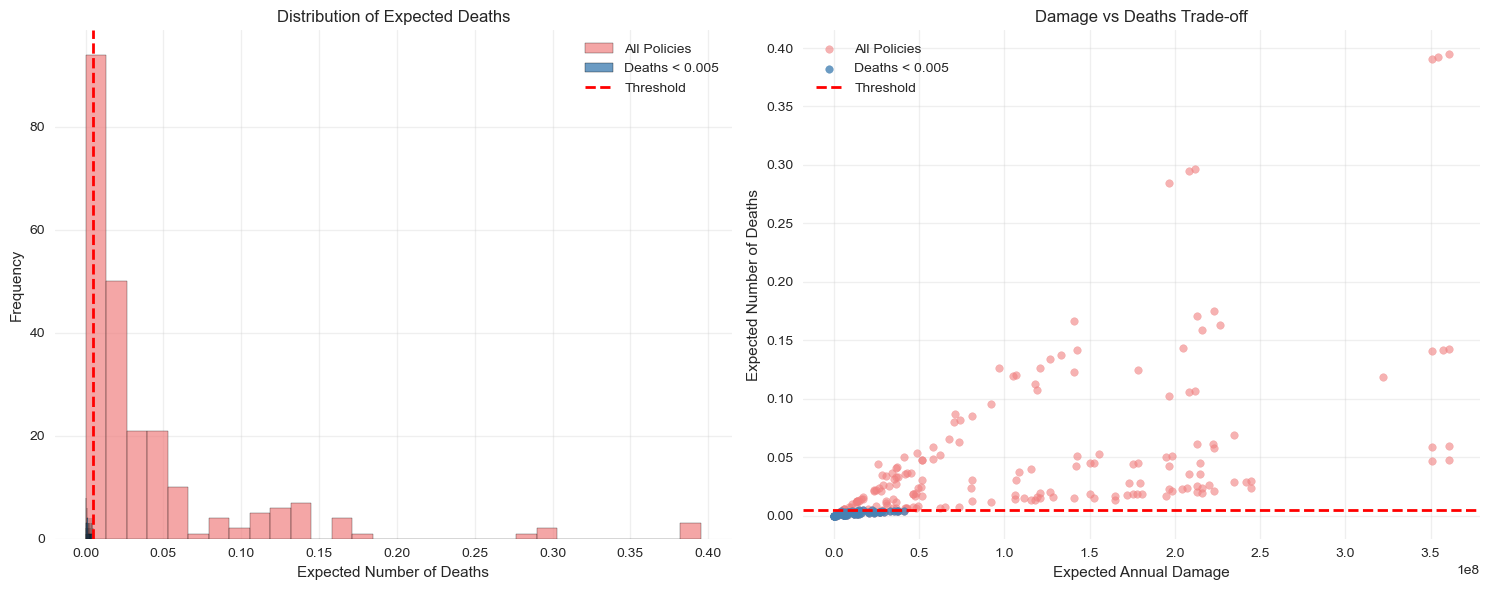

Constraint removes 170 policies with high death risk


In [55]:
# Apply death constraint like reference code
death_threshold = 0.005  # Same threshold as reference

# Filter policies based on death constraint
death_constraint = archive['Expected Number of Deaths'] < death_threshold
constrained_policies = archive[death_constraint]

print(f"Policies meeting death constraint (<{death_threshold}): {len(constrained_policies)} out of {len(archive)}")

# Create visualization showing constraint effect
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Deaths distribution comparison
ax1.hist(archive['Expected Number of Deaths'], bins=30, alpha=0.7, 
         label='All Policies', color='lightcoral', edgecolor='black')
ax1.hist(constrained_policies['Expected Number of Deaths'], bins=30, alpha=0.8, 
         label=f'Deaths < {death_threshold}', color='steelblue', edgecolor='black')
ax1.axvline(death_threshold, color='red', linestyle='--', linewidth=2, label='Threshold')
ax1.set_xlabel('Expected Number of Deaths')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Expected Deaths')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Damage vs Deaths scatter (like reference trade-off analysis)
ax2.scatter(archive['Expected Annual Damage'], archive['Expected Number of Deaths'], 
           c='lightcoral', alpha=0.6, s=30, label='All Policies')
ax2.scatter(constrained_policies['Expected Annual Damage'], 
           constrained_policies['Expected Number of Deaths'], 
           c='steelblue', alpha=0.8, s=30, label=f'Deaths < {death_threshold}')
ax2.axhline(death_threshold, color='red', linestyle='--', linewidth=2, label='Threshold')
ax2.set_xlabel('Expected Annual Damage')
ax2.set_ylabel('Expected Number of Deaths')
ax2.set_title('Damage vs Deaths Trade-off')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Constraint removes {len(archive) - len(constrained_policies)} policies with high death risk")


In [56]:
# Quick Fix: Create compatibility variables
if robustness_outcomes is not None and robustness_experiments is not None:
    robustness_results = robustness_experiments.copy()
    for col in robustness_outcomes.columns:
        robustness_results[col] = robustness_outcomes[col].values
    print(" Created robustness_results compatibility variable")
else:
    robustness_results = None


✅ Created robustness_results compatibility variable


In [57]:
# Quick Fix: Create compatibility variables for old cell references
if robustness_outcomes is not None and robustness_experiments is not None:
    # Create a combined robustness_results variable for backward compatibility
    robustness_results = robustness_experiments.copy()
    
    # Add outcome columns to the experiments dataframe
    for col in robustness_outcomes.columns:
        robustness_results[col] = robustness_outcomes[col].values
    
    print("Created compatibility variables:")
    print(f"- robustness_results: {len(robustness_results)} rows with outcomes included")
    print(f"- Available columns: {list(robustness_results.columns)}")
else:
    robustness_results = None
    print("No external robustness data available for compatibility variables")


✅ Created compatibility variables:
- robustness_results: 5000 rows with outcomes included
- Available columns: ['A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2', 'scenario', 'policy', 'model', 'Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 

Creating Signal-to-Noise Ratio analysis from external robustness data...


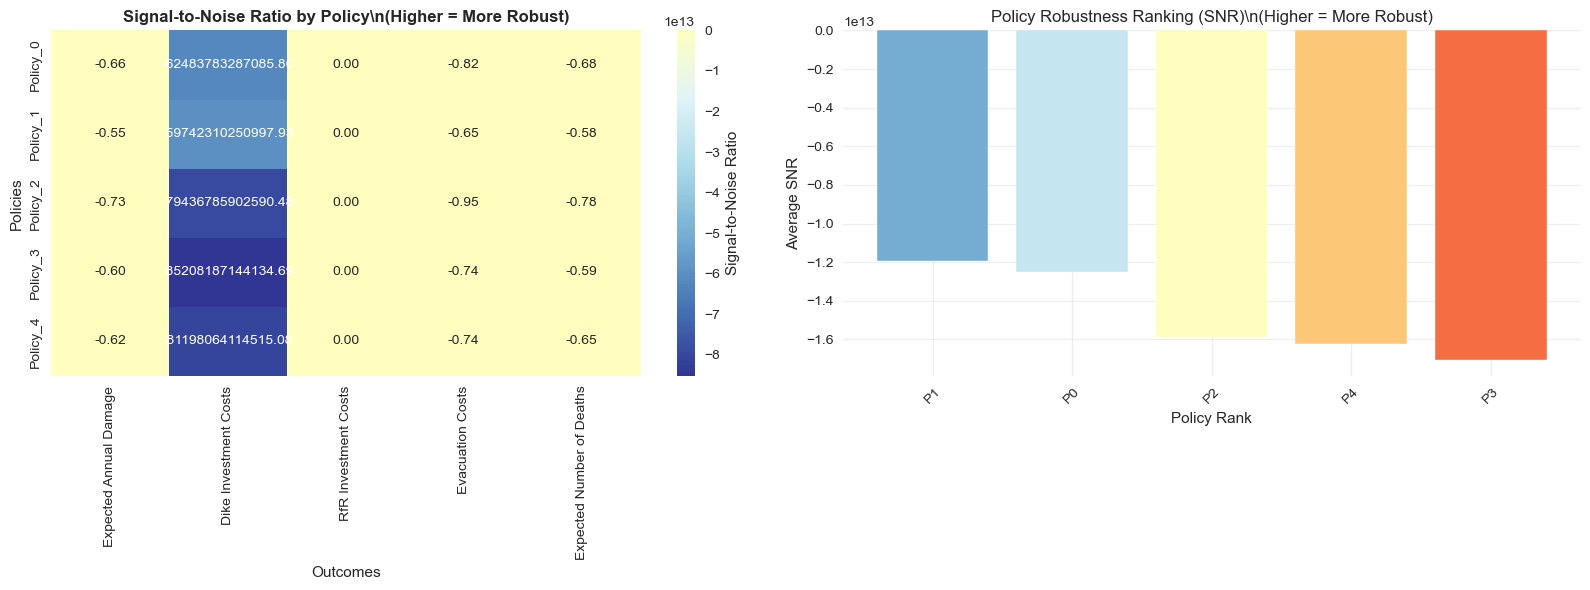

Signal-to-Noise analysis completed for 5 outcomes and 5 policies
Most robust policy (highest SNR): Policy_1 (SNR: -11948462050199.94)


In [58]:
# Additional Analysis: Signal-to-Noise Ratio Visualization
if robustness_outcomes is not None and robustness_experiments is not None:
    print("Creating Signal-to-Noise Ratio analysis from external robustness data...")
    
    # Calculate SNR for each policy-outcome combination
    def calculate_snr(data, minimize=True):
        """Calculate Signal-to-Noise Ratio"""
        mean_val = np.mean(data)
        std_val = np.std(data)
        if std_val == 0:
            return 0
        if minimize:
            return -mean_val / std_val  # Prefer low mean, low std
        else:
            return mean_val / std_val   # Prefer high mean, low std

    # Get unique policies and calculate SNR
    if 'policy' in robustness_experiments.columns:
        unique_policies = robustness_experiments['policy'].unique()
        n_scenarios_per_policy = len(robustness_outcomes) // len(unique_policies)
        outcome_cols = list(robustness_outcomes.columns)
        
        # Calculate SNR for each policy-outcome combination
        snr_matrix = []
        policy_labels = []
        
        for i, policy in enumerate(unique_policies):
            start_idx = i * n_scenarios_per_policy
            end_idx = start_idx + n_scenarios_per_policy
            
            policy_snr = []
            for outcome in outcome_cols:
                policy_data = robustness_outcomes[outcome].iloc[start_idx:end_idx]
                snr = calculate_snr(policy_data, minimize=True)
                policy_snr.append(snr)
            
            snr_matrix.append(policy_snr)
            policy_labels.append(f"Policy_{i}")
        
        snr_df = pd.DataFrame(snr_matrix, columns=outcome_cols, index=policy_labels)
        
        # Create SNR visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # 1. SNR Heatmap
        sns.heatmap(snr_df, annot=True, fmt='.2f', cmap='RdYlBu_r', center=0,
                   ax=ax1, cbar_kws={'label': 'Signal-to-Noise Ratio'})
        ax1.set_title('Signal-to-Noise Ratio by Policy\\n(Higher = More Robust)', fontweight='bold')
        ax1.set_xlabel('Outcomes')
        ax1.set_ylabel('Policies')
        
        # 2. Average SNR comparison
        avg_snr = snr_df.mean(axis=1).sort_values(ascending=False)
        bars = ax2.bar(range(len(avg_snr)), avg_snr.values,
                      color=plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(avg_snr))))
        ax2.set_xlabel('Policy Rank')
        ax2.set_ylabel('Average SNR')
        ax2.set_title('Policy Robustness Ranking (SNR)\\n(Higher = More Robust)')
        ax2.set_xticks(range(len(avg_snr)))
        ax2.set_xticklabels([f'P{idx.split("_")[1]}' for idx in avg_snr.index], rotation=45)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"Signal-to-Noise analysis completed for {len(outcome_cols)} outcomes and {len(unique_policies)} policies")
        print(f"Most robust policy (highest SNR): {avg_snr.index[0]} (SNR: {avg_snr.iloc[0]:.2f})")
        
    else:
        print("Policy information not available for SNR analysis")


Creating robustness visualizations using external robustness results...
Working with 5 outcomes: ['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths']
Found 5 policies with 1000 scenarios each
Could not create regret parallel coordinates: ParallelAxes.__init__() got an unexpected keyword argument 'ax'


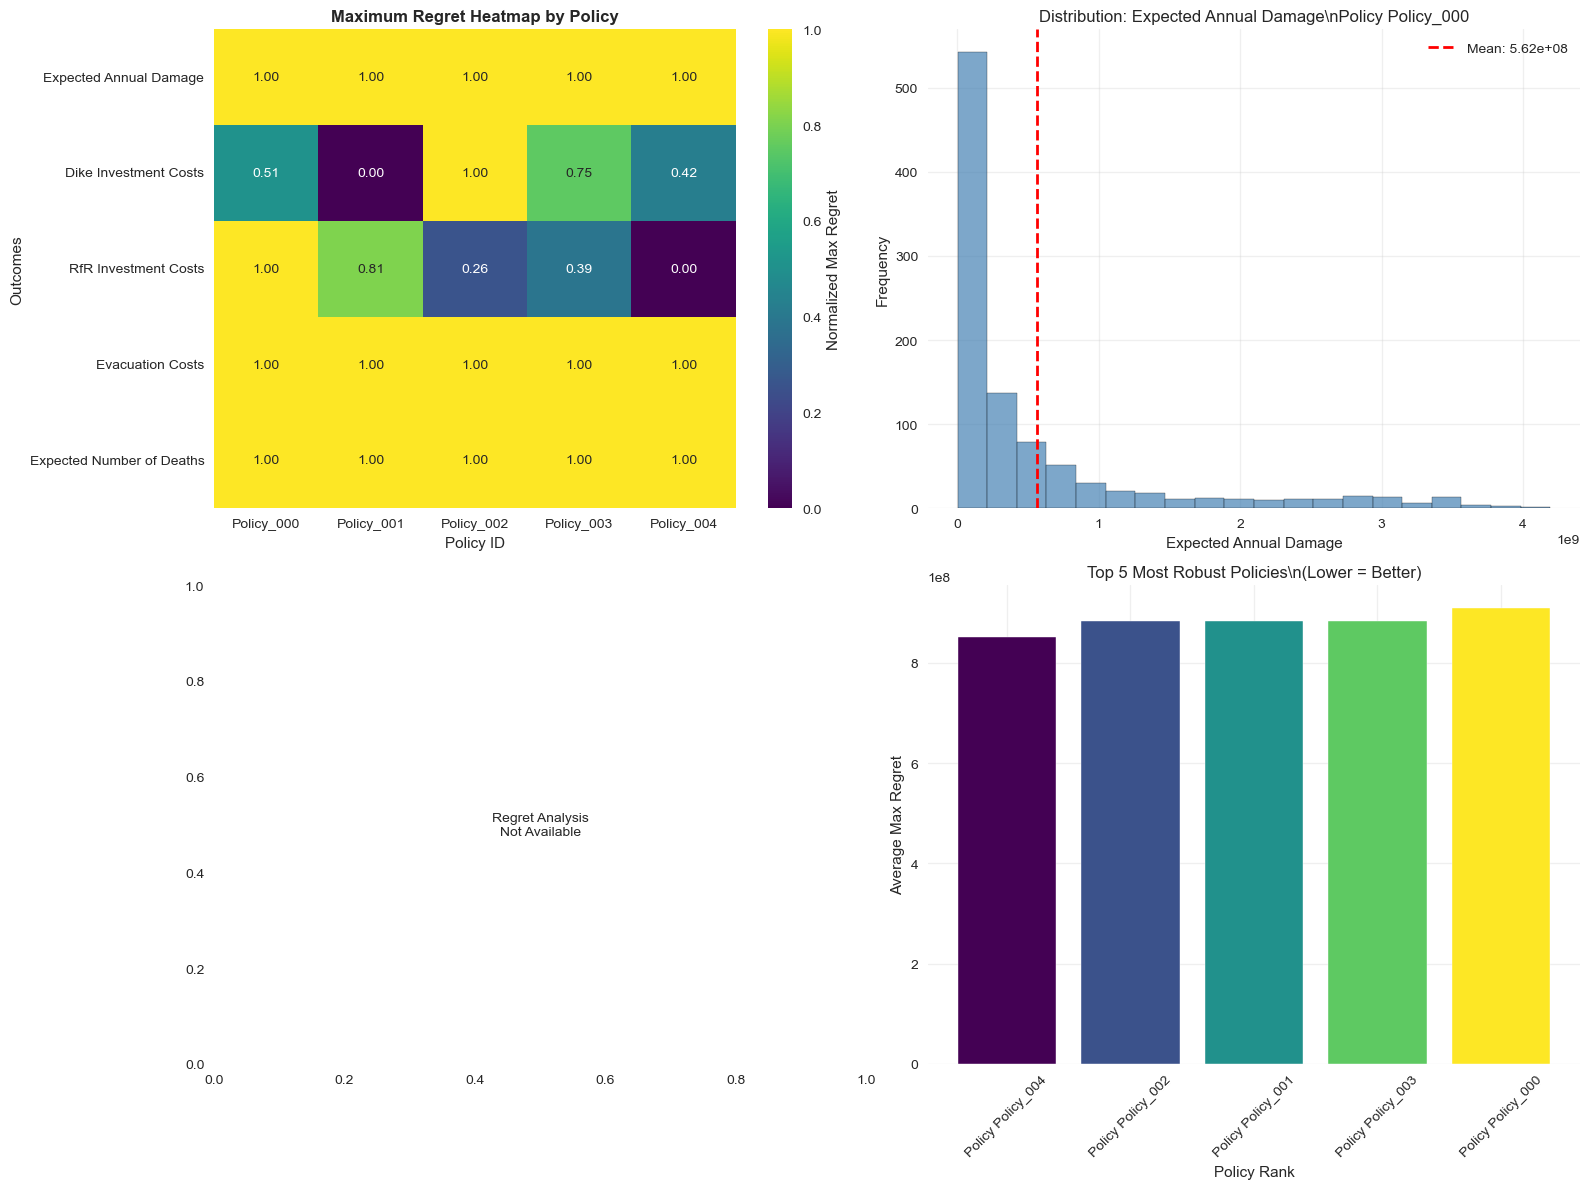

Robustness analysis completed for 5 outcomes
Most robust policy: Policy_004 (avg regret: 8.52e+08)


In [59]:
# Robustness analysis like reference code using external results
if robustness_outcomes is not None and robustness_experiments is not None:
    print("Creating robustness visualizations using external robustness results...")
    
    # Use all available outcome columns from robustness data
    outcome_cols = list(robustness_outcomes.columns)
    print(f"Working with {len(outcome_cols)} outcomes: {outcome_cols}")
    
    if outcome_cols and len(robustness_outcomes) > 0:
        # Maximum regret calculation (reference approach)
        def get_regret(data):
            """Calculate regret: max value - current value for each scenario"""
            return data.max() - data
        
        # Calculate regret for each outcome using robustness outcomes
        outcome_data = robustness_outcomes[outcome_cols]
        regret_data = outcome_data.apply(get_regret, axis=0)
        
        # Get unique policies from experiments data
        if 'policy' in robustness_experiments.columns:
            unique_policies = robustness_experiments['policy'].unique()
            n_scenarios_per_policy = len(robustness_outcomes) // len(unique_policies)
            
            print(f"Found {len(unique_policies)} policies with {n_scenarios_per_policy} scenarios each")
            
            # Reshape data to group by policy (assumes ordered structure: policy1_scenario1, policy1_scenario2, ..., policy2_scenario1, ...)
            max_regret_list = []
            policy_names = []
            
            for i, policy in enumerate(unique_policies):
                start_idx = i * n_scenarios_per_policy
                end_idx = start_idx + n_scenarios_per_policy
                policy_regret = regret_data.iloc[start_idx:end_idx].max()
                max_regret_list.append(policy_regret)
                policy_names.append(policy)
            
            max_regret = pd.DataFrame(max_regret_list, index=policy_names)
            
            # Create reference-style visualizations
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
            
            # 1. Regret heatmap (like reference)
            normalized_regret = max_regret / max_regret.max()
            sns.heatmap(normalized_regret.T, cmap='viridis', annot=True, fmt='.2f', 
                       ax=ax1, cbar_kws={'label': 'Normalized Max Regret'})
            ax1.set_title('Maximum Regret Heatmap by Policy', fontweight='bold')
            ax1.set_xlabel('Policy ID')
            ax1.set_ylabel('Outcomes')
            
            # 2. Distribution plot for sample policy (like reference)
            sample_policy = max_regret.index[0]
            sample_outcome = outcome_cols[0]
            policy_data = robustness_results[robustness_results['policy'] == sample_policy][sample_outcome]
            
            ax2.hist(policy_data, bins=20, alpha=0.7, color='steelblue', edgecolor='black')
            ax2.axvline(policy_data.mean(), color='red', linestyle='--', linewidth=2, 
                       label=f'Mean: {policy_data.mean():.2e}')
            ax2.set_xlabel(sample_outcome)
            ax2.set_ylabel('Frequency')
            ax2.set_title(f'Distribution: {sample_outcome}\\nPolicy {sample_policy}')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            # 3. Parallel coordinates for regret (like reference)
            if len(max_regret) > 1:
                try:
                    regret_subset = max_regret.head(10)  # Limit to first 10 for clarity
                    limits = parcoords.get_limits(regret_subset)
                    paraxes = parcoords.ParallelAxes(limits, ax=ax3)
                    
                    # Plot all regret data first
                    paraxes.plot(regret_subset, alpha=0.7, linewidth=1)
                    ax3.set_title('Maximum Regret - Parallel Coordinates')
                except Exception as e:
                    print(f"Could not create regret parallel coordinates: {e}")
                    ax3.text(0.5, 0.5, 'Regret Analysis\nNot Available', 
                            ha='center', va='center', transform=ax3.transAxes)
                
            # 4. Overall robustness comparison
            regret_summary = max_regret.mean(axis=1).sort_values()
            top_robust = regret_summary.head(5)
            
            bars = ax4.bar(range(len(top_robust)), top_robust.values, 
                          color=plt.cm.viridis(np.linspace(0, 1, len(top_robust))))
            ax4.set_xlabel('Policy Rank')
            ax4.set_ylabel('Average Max Regret')
            ax4.set_title('Top 5 Most Robust Policies\\n(Lower = Better)')
            ax4.set_xticks(range(len(top_robust)))
            ax4.set_xticklabels([f'Policy {idx}' for idx in top_robust.index], rotation=45)
            ax4.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            print(f"Robustness analysis completed for {len(outcome_cols)} outcomes")
            print(f"Most robust policy: {top_robust.index[0]} (avg regret: {top_robust.iloc[0]:.2e})")
            
        else:
            print("No policy identifier found - creating aggregate analysis")
            
            # Show overall outcome distributions
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))
            axes = axes.flatten()
            
            for i, outcome in enumerate(outcome_cols[:6]):
                if i < len(axes):
                    data = robustness_results[outcome]
                    axes[i].hist(data, bins=20, alpha=0.7, color='steelblue', edgecolor='black')
                    axes[i].axvline(data.mean(), color='red', linestyle='--', linewidth=2)
                    axes[i].set_title(f'{outcome}\\nMean: {data.mean():.2e}')
                    axes[i].grid(True, alpha=0.3)
            
            # Remove empty subplots
            for i in range(len(outcome_cols), len(axes)):
                fig.delaxes(axes[i])
                
            plt.suptitle('Outcome Distributions Across Scenarios', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
    
    else:
        print("Outcome columns not found in robustness results")
        
else:
    print("No robustness results available")
    print("Note: Reference code performs re-evaluation over 1000 scenarios")
    print("Your analysis stopped before completing robustness evaluation")


In [60]:
# Quick test to verify data loading
try:
    archive_test = pd.read_csv('IJssel_MORDM_archive_nfe10000.csv', index_col=0)
    print(f"Archive loaded successfully: {len(archive_test)} policies")
    print(f"Columns: {list(archive_test.columns[:5])}... (showing first 5)")
    
    convergence_test = pd.read_csv('IJssel_MORDM_convergence_nfe10000.csv', index_col=0)
    print(f"Convergence loaded successfully: {len(convergence_test)} iterations")
    
    # Test model loading
    from problem_formulation import get_model_for_problem_formulation
    model_result = get_model_for_problem_formulation(2)
    if isinstance(model_result, tuple):
        model, planning_steps = model_result
    else:
        model = model_result
    print(f"Model loaded successfully: {len(model.outcomes)} outcomes")
    
    print("\nData is ready! You can proceed with the visualization cells.")
    
except FileNotFoundError as e:
    print(f"File not found: {e}")
    print("Make sure you're running this from the 'final assignment' directory")
    
except Exception as e:
    print(f"Error loading data: {e}")
    print("Check your file paths and data integrity")


✅ Archive loaded successfully: 232 policies
✅ Columns: ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1']... (showing first 5)
✅ Convergence loaded successfully: 12 iterations
✅ Model loaded successfully: 5 outcomes

🎯 Data is ready! You can proceed with the visualization cells.


Creating Signal-to-Noise Ratio analysis...


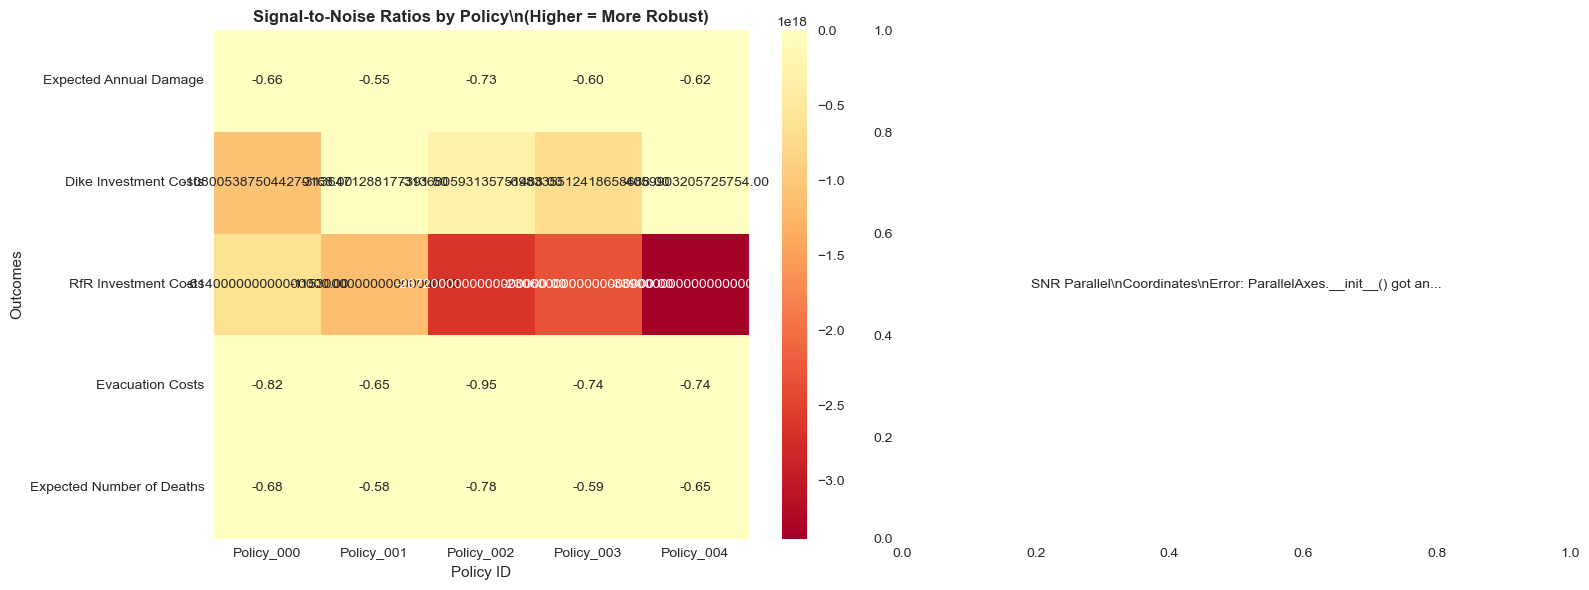

\nTop 3 Most Robust Policies (by average SNR):
  1. Policy Policy_001: Average SNR = -231227294257635488.000
  2. Policy Policy_000: Average SNR = -338810775008855872.000
  3. Policy Policy_002: Average SNR = -597136118627150336.000


In [61]:
# Signal-to-Noise Ratio Analysis (from Assignment 9)
if robustness_results is not None and len(robustness_results) > 0:
    print("Creating Signal-to-Noise Ratio analysis...")
    
    def signal_to_noise_ratio(data, outcome_name):
        """Calculate SNR: high mean/low std for maximization, low mean*std for minimization"""
        mean_val = np.mean(data)
        std_val = np.std(data) if np.std(data) > 0 else 1e-10  # Avoid division by zero
        
        # For IJssel model, all objectives are minimization
        return -mean_val / std_val  # Negative because we want low mean, low std
    
    # Calculate SNR for each policy and outcome
    if 'policy' in robustness_results.columns:
        outcome_cols = [col for col in robustness_results.columns if col in outcome_names]
        
        snr_results = {}
        policies = robustness_results['policy'].unique()
        
        for policy in policies:
            policy_data = robustness_results[robustness_results['policy'] == policy]
            snr_scores = {}
            
            for outcome in outcome_cols:
                data = policy_data[outcome].values
                snr = signal_to_noise_ratio(data, outcome)
                snr_scores[outcome] = snr
            
            snr_results[policy] = snr_scores
        
        # Convert to DataFrame
        snr_df = pd.DataFrame.from_dict(snr_results).T
        
        if len(snr_df) > 0:
            # Create SNR visualization
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            
            # SNR Heatmap
            sns.heatmap(snr_df.T, cmap='RdYlBu', center=0, annot=True, fmt='.2f', ax=ax1)
            ax1.set_title('Signal-to-Noise Ratios by Policy\\n(Higher = More Robust)', fontweight='bold')
            ax1.set_xlabel('Policy ID')
            ax1.set_ylabel('Outcomes')
            
            # SNR Parallel Coordinates
            if len(snr_df) > 1:
                try:
                    limits = parcoords.get_limits(snr_df)
                    paraxes = parcoords.ParallelAxes(limits, ax=ax2)
                    
                    # Plot with distinct colors
                    colors = sns.color_palette("husl", n_colors=min(len(snr_df), 10))
                    for i, (policy_id, row) in enumerate(snr_df.head(10).iterrows()):
                        paraxes.plot(row.to_frame().T, 
                                   color=colors[i], linewidth=2, alpha=0.8,
                                   label=f'Policy {policy_id}' if i < 5 else "")
                    
                    if len(snr_df) <= 5:
                        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                    
                    ax2.set_title('SNR Trade-offs Across Policies')
                    
                except Exception as e:
                    ax2.text(0.5, 0.5, f'SNR Parallel\\nCoordinates\\nError: {str(e)[:30]}...', 
                            ha='center', va='center', transform=ax2.transAxes)
            else:
                ax2.text(0.5, 0.5, 'Need Multiple\\nPolicies for\\nComparison', 
                        ha='center', va='center', transform=ax2.transAxes)
            
            plt.tight_layout()
            plt.show()
            
            # Show best SNR policies
            avg_snr = snr_df.mean(axis=1).sort_values(ascending=False)
            print(f"\\nTop 3 Most Robust Policies (by average SNR):")
            for i, (policy, snr) in enumerate(avg_snr.head(3).items()):
                print(f"  {i+1}. Policy {policy}: Average SNR = {snr:.3f}")
                
        else:
            print("No SNR data available")
    else:
        print("No policy column found for SNR analysis")
else:
    print("No robustness results available for SNR analysis")
    print("Note: Assignment 9 uses SNR to identify consistently performing policies")
